This experiment is the the first experiment of the <b>Adaptive Conditional Neural Movement Primitives </b>

This experiment does not involve any external task parameters 

#### The LfD part of the code is taken from https://github.com/rssCNMP/CNMP

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import math
import random
import collections
from keras.models import Sequential
from keras.layers import TimeDistributed,Dense,Activation,Layer,Input,Average,Concatenate,Conv2D,MaxPooling2D,Flatten,Lambda
from keras.models import Model,clone_model
from keras.optimizers import Adam
from copy import deepcopy
from tqdm import tqdm

/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tuluhan/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

In [2]:
#demostration parameters
d = np.array([[0.2,0],[0.4,0],[0.6,0],[-0.2,0],[-0.4,0],[-0.6,0],[0.8,0]])
n_max=5
global_reward=0
global_prop=0

## Demonstrations:

Demonstration function is given and demonstrations are plotted. Extrapolation point is shown on the graph with magenta.

In [3]:
def demonstration(p, x, noise = 0):
    f = d[p,0]*(np.exp(-np.power(x+0.25,2.)/(2*np.power(0.15,2.)))+np.exp(-np.power(x-0.25,2.)/(2*np.power(0.15,2.)))-0.25)
    return f+(noise*(random.random()-0.5)/100.)

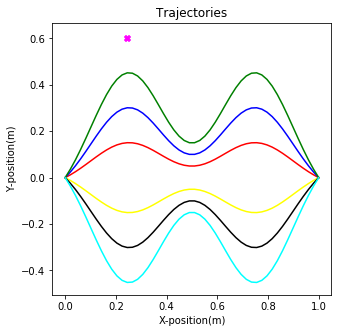

In [4]:
fig = plt.figure(figsize=(5,5))
x = np.linspace(-0.5,0.5,50)

times = x+0.5
y = np.zeros((7,50))
for p in range(7):
        for i in range(50):
            y[p,i] = demonstration(p,x[i])
        if p==0:
            plt.plot(times,y[p],color='red')
        if p==1:
            plt.plot(times,y[p],color='blue')
        if p==2:
            plt.plot(times,y[p],color='green')
        if p==3:
            plt.plot(times,y[p],color='yellow')
        if p==4:
            plt.plot(times,y[p],color='black')
        if p==5:
            plt.plot(times,y[p],color='cyan')
plt.title('Trajectories')
plt.ylabel('Y-position(m)')
plt.xlabel('X-position(m)')

cx1=times[0]
cy1=y[6,0]
cx2=times[12]
cy2=y[6,12]
cx3=times[49]
cy3=y[6,49]

plt.scatter(cx2,cy2,marker="X",color='magenta')
plt.show()


## Loading model inputs

* <b>n_max</b>: Hyperparameter that decides to the maximum number of observations CNMP uses. In this experiment, it is set to 5.
* <b>n</b>: Number of observations taken for one time step.

* <b>p</b>: Number that specifies the taken expert demonstration.

* <b>observation</b>: The input vector for CNMP network, which consists of n observations.

* <b>target</b>: A random time point used for the training

* <b>Y</b>: The matrix that contains expert demonstrations.



In [5]:
def get_train_sample():
    observation = np.zeros((1,n_max,2))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,1))
    p = random.randint(0, 5)
    n = random.randint(1,n_max)
    perm = np.random.permutation(50) #time-points are randomized
    for i in range(n):
        observation[0,i] = [times[perm[i]],y[p,perm[i]]]
        observation_flag[0,0,i] = 1./n
    target[0,0,0] = times[perm[n]]
    return [observation,observation_flag,target], [[[y[p,perm[n]],0.]]],p

### Plot function for CNMP training
* Data is collected similar to get_train_sample function where the observation points are given as c_x,c_y instead of choosing randomly as in the training procedure.
* In order to obtain a trajectory, target value is asked to the network for all time steps.
* Old expert trajectories are shown with gray, whereas prediction is plotted with red.

In [6]:
def test_plt_model(c_x,c_y):
    pred_y = np.zeros(50)
    pred_std = np.zeros(50)
    observation = np.zeros((1,n_max,2))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,1))
    observation[0,0] = [c_x,c_y]
    observation_flag[0,0,0] = 1.
    fig = plt.figure(figsize=(5,5))
    for i in range(50):
        target[0,0,0] = times[i]
        pred = model.predict([observation,observation_flag,target])[0][0]
        pred_std[i] = math.log(1+math.exp(pred[1]))
        pred_y[i] = pred[0]   
    for i in range(6):
        
        if i==0:
            plt.plot(times,y[i],color='red')
        if i==1:
            plt.plot(times,y[i],color='blue')
        if i==2:
            plt.plot(times,y[i],color='green')
        if i==3:
            plt.plot(times,y[i],color='yellow')
        if i==4:
            plt.plot(times,y[i],color='black')
        if i==5:
            plt.plot(times,y[i],color='cyan')
        if i==6:
            plt.plot(times,y[i],color='magenta')
        
          
    plt.plot(times,pred_y,color='magenta',label='prediction')
    plt.scatter(c_x,c_y,marker="X",color='magenta')
    plt.title('Trajectories')
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.ylim(top=0.7)
    plt.figure(figsize=(20,10))
    plt.show()      

### Plot function for RL training
* Data is collected similar to get_train_sample function where the observation points are given as extrapolation case.
* In order to obtain a trajectory, target value is asked to the network for all time steps.
* Old expert trajectories are shown with gray, whereas prediction is plotted with red.

In [7]:
def test_plt_model5(c_x1,c_y1,c_x2,c_y2,c_x3,c_y3,case):
    global y
    pred_y = np.zeros(50)
    pred_std = np.zeros(50)
    observation = np.zeros((1,n_max,2))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,1))
    observation[0,0] = [c_x1,c_y1]
    observation[0,1] = [c_x2,c_y2]
    observation[0,2] = [c_x3,c_y3]
    observation_flag[0,0,0] = 1./3
    observation_flag[0,0,1] = 1./3
    observation_flag[0,0,2] = 1./3
    fig = plt.figure(figsize=(5,5))
    for i in range(50):
        target[0,0,0] = times[i]
        pred= model2.predict([[states1[i]],[states2[i]],[states3[i]]])[0][0]
        pred_std[i] = math.log(1+math.exp(pred[1]))
        pred_y[i] = pred[0]   
    for i in range(6):        
        if i==0:
            plt.plot(times,y[i],color='red')
        if i==1:
            plt.plot(times,y[i],color='blue')
        if i==2:
            plt.plot(times,y[i],color='green')
        if i==3:
            plt.plot(times,y[i],color='yellow')
        if i==4:
            plt.plot(times,y[i],color='black')
        if i==5:
            plt.plot(times,y[i],color='cyan')
        if i==6:
            plt.plot(times,y[i],color='magenta')
    y[6]=pred_y
    plt.plot(times,pred_y,color='magenta',label='prediction')
    
    plt.scatter(c_x2,c_y2,marker="X",color='magenta')
    plt.scatter(c_x1,c_y1,marker="X",color='magenta')
    plt.scatter(c_x3,c_y3,marker="X",color='magenta')
    
    plt.title('Trajectories')
    
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    #plt.legend(loc="upper right")

    plt.show() 

### custom_loss():
* Calculates log probability of the true value of the target point according to the multivariate Gaussian constructed by predicted means and stds
* Returns minus of that value

In [8]:
def custom_loss(y_true, y_pred):
    mean, log_sigma = tf.split(y_pred, 2, axis=-1)
    y_target, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_target))
    return loss

## The LfD model:
* Encoder part of the network forms a representation for the observations. 
* Decoder part of the network predicts a value for the target value and supervised loss is backpropagated
* Representation model gives the representation for the observations and the target as output for the reinforcement learning agent input.

In [9]:
observation_layer = Input(shape=(n_max,2))
observation_flag_layer=Input(shape=(1,n_max)) 

observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_layer)
observation_encoded = TimeDistributed(Dense(64, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(32, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(16, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(8))(observation_encoded)

matmul_layer=Lambda(lambda x:(tf.matmul(x[0],x[1])), output_shape =(1,8))

representation=matmul_layer([observation_flag_layer,observation_encoded])

target_layer = Input(shape=(1,1))

decoder_input = Concatenate(axis=2)([representation, target_layer])

decoder = Dense(128, activation='relu')(decoder_input)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(2)(decoder)

#next_model_input=Concatenate(axis=2)([decoder_input, output_layer])
next_model_input=decoder_input

model = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=output_layer)
model.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model.summary()

representation_model = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=next_model_input)





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 2)         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 128)       384         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 64)        8256        time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 5, 32)        2080        time_distributed_2[0][0]         
________________________________________________________________________________________

### LfD model training(Skip to next two cells to use pre-trained model)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

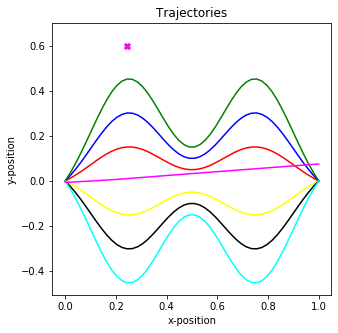

<Figure size 1440x720 with 0 Axes>

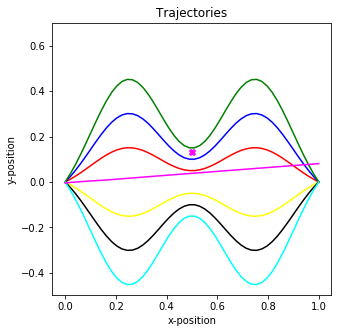

<Figure size 1440x720 with 0 Axes>

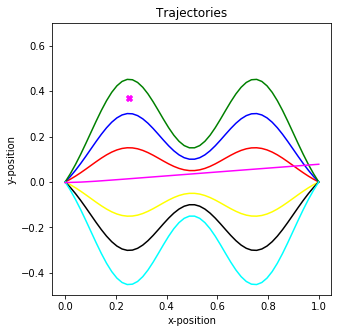

<Figure size 1440x720 with 0 Axes>

step 0
loss 0.6099307537078857


KeyboardInterrupt: 

In [10]:
import time
import pylab as pl
from IPython import display
training_loss2 = np.zeros(2000)
for step in range(250000):
    inp,out,sample = get_train_sample()
    data2 = model.fit(inp,out,batch_size=1,verbose=0)

    if step % 10000 == 0:
        display.clear_output(wait=True)
        display.display(pl.gcf())
        inp,out,sample = get_train_sample()
        test_plt_model(cx2,0.6)
        test_plt_model(c_x=0.5,c_y=0.13)
        test_plt_model(c_x=0.25,c_y=0.37)
        print ('step', step)
        print ('loss', data2.history['loss'][0])

        mean_loss2 = np.zeros((100))
        for i in range(100):
            mean_loss2[i] = np.mean(training_loss2[i*20:(i+1)*20])



In [ ]:
model.save('LfD_experiment1.h5')

In [11]:
model.load_weights('LfD_experiment1.h5')

### Extrapolation performance of LfD framework

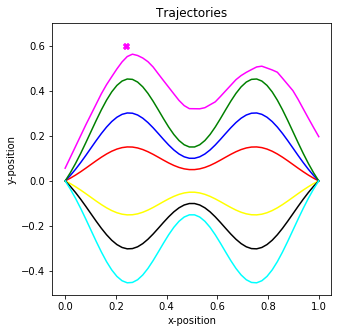

<Figure size 1440x720 with 0 Axes>

In [12]:
test_plt_model(c_x=0.24,c_y=0.6)

### custom_loss2():
* The policy gradient loss where a Gaussian distribution is used for action values .
* Very similar to maximum-likelyhood loss of CNMP except that q_value(reward) is used to enhance the gradient 

In [13]:
def custom_loss2(taken, predicted):
    predicted_action_mean, predicted_action_sigma = tf.split(predicted, 2, axis=-1)
    taken_action, q_value =tf.split(taken,2,axis=-1)
    #sigma = tf.nn.softplus(predicted_action_sigma)
    square_loss=np.square(taken_action-predicted_action_mean)
    loss = (1./2.)*square_loss*q_value
    return loss

## The reinforcement learning model:

* Same as LfD network


In [14]:
observation_layer = Input(shape=(n_max,2))
observation_flag_layer=Input(shape=(1,n_max)) 

observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_layer)
observation_encoded = TimeDistributed(Dense(64, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(32, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(16, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(8))(observation_encoded)

matmul_layer=Lambda(lambda x:(tf.matmul(x[0],x[1])), output_shape =(1,8))

representation=matmul_layer([observation_flag_layer,observation_encoded])

target_layer = Input(shape=(1,1))

decoder_input = Concatenate(axis=2)([representation, target_layer])

decoder = Dense(128, activation='relu')(decoder_input)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(2)(decoder)

#next_model_input=Concatenate(axis=2)([decoder_input, output_layer])
next_model_input=decoder_input

model2 = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=output_layer)
model2.compile(optimizer = Adam(lr = 5e-5),loss=custom_loss2)
model2.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 5, 2)         0                                            
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 5, 128)       384         input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 5, 64)        8256        time_distributed_6[0][0]         
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 5, 32)        2080        time_distributed_7[0][0]         
____________________________________________________________________________________________

#### The weights of LfD network are copied to bootstrap reinforcement learning agent

In [15]:
model2.load_weights('LfD_experiment1.h5')

#### The observations(start-extrapolation(via)-end points) and all time points for trajectory are recorded as states 


In [16]:
cx1=0
cy2=0
cx2=0.24  #uncomment and change values for different extrapolation points
cy2=0.6
cx3=1
cy3 = 0
pred_y = np.zeros(50)
pred_std = np.zeros(50)
states1=[]
states2=[]
states3=[]
observation = np.zeros((1,n_max,2))
observation_flag = np.zeros((1,1,n_max))
target = np.zeros((1,1,1))
observation[0,0] = [cx1,cy1]
observation[0,1] = [cx2,cy2]
observation[0,2] = [cx3,cy3]
observation_flag[0,0,0] = 1./3
observation_flag[0,0,1] = 1./3
observation_flag[0,0,2] = 1./3
for i in range(50):
    target[0,0,0] = times[i]
    if(i==0):
        states1=observation
        states2=observation_flag
        states3=target
    else:

        states1=np.concatenate((states1,observation),axis=0)
        states2=np.concatenate((states2,observation_flag),axis=0)
        states3=np.concatenate((states3,target),axis=0)
states=[states1,states2,states3]
print(np.shape(states1))
print(np.shape(states2))
print(np.shape(states3))

(50, 5, 2)
(50, 1, 5)
(50, 1, 1)


In [17]:
max_reward=-100.0
best_step=0
rewards_upto_steps=[]
var = 0.1

### Mismatch function to measure the differences of old and new policy

In [18]:
def mismatch_func(actions1,actions2):
    
    error=0
    
    for i in range(50):
        error2=np.square(actions1[i]-actions2[i])
        error=max(error,error2)
    return error

#### Gaussian Pdf

In [19]:
def normpdf(x, mean, sd):
    denom = sd*(2*math.pi)**0.5
    num= math.exp(-0.5*((x-mean)/float(sd))**2)
    return num/denom

## Reinforcement Learning
* <b>How to train</b>: At first, the RL network is trained in supervised learning setting exactly same as in CNMP. Than, the standard policy gradient algorithm(Vanilla policy gradient) is implemented.

* <b>model2</b>: The network that is trained in reinforcement learning setting.

* <b>cx1,cy1,cx2,cy2,cx3,cy3</b>: The extrapolation observations for the task

* <b>reward</b>: Denotes for the reward that stochastic Gaussian policy obtains. The reward is calculated as the distance to the observation point of the policy output only for the timestep of the observation. Otherwise, it is 0.

* <b>reward2</b>: Denotes for the reward that average policy obtains. So, the baseline is selected as the average reward for policy gradient algorithm. 

* <b>model_reward,max_reward</b>: These variables are used to save the policy as <b>best_validation.h5</b> that gives the highest reward.



In [20]:
def rl_agent(cx1,cy1,cx2,cy2,cx3,cy3,step): 
    actions, rewards,rewards2 = [], [], []
    action_prob = []
    actions_mean = []
    global max_reward
    global best_step
    global rewards_upto_steps
    for i in range(50):        #SL part of training
        
        inp,out,sample = get_train_sample()
        out[0][0][1]=1        
        data = model2.fit(inp,out,batch_size=1,verbose=0)
    
    model_reward=0
    for i in range(50):        #RL part of training 
        reward2 = 0
        pred= model2.predict([[states1[i]],[states2[i]],[states3[i]]])[0][0]
        actions_mean.append(pred[0])
        if(np.absolute(times[i]-cx1)<0.01):
            reward2=-np.absolute(pred[0]-cy1)
            model_reward+=reward2
        elif(np.absolute(times[i]-cx2)<0.01):
            reward2=-np.absolute(pred[0]-cy2)
            model_reward+=reward2
        elif(np.absolute(times[i]-cx3)<0.01):
            reward2=-np.absolute(pred[0]-cy3)
            model_reward+=reward2
        else:
            reward2-=0
            model_reward+=reward2
        rewards2.append(reward2)
    var = min(0.1,np.absolute(model_reward))
    
    for i in range(50):        #RL part of training 
        reward = 0
        pred= model2.predict([[states1[i]],[states2[i]],[states3[i]]])[0][0]
        selected_action = np.random.normal(pred[0], var, 1)
        actions.append(selected_action[0])
        action_prob.append(normpdf(selected_action[0], pred[0], var))
        
        if(np.absolute(times[i]-cx1)<0.01):
            reward=-np.absolute(selected_action[0]-cy1)
        elif(np.absolute(times[i]-cx2)<0.01):
            reward=-np.absolute(selected_action[0]-cy2)
        elif(np.absolute(times[i]-cx3)<0.01):
            reward=-np.absolute(selected_action[0]-cy3)
        else:
            reward-=0
        rewards.append(reward)
    
    rewards_upto_steps.append(model_reward)
    if(model_reward>max_reward):
        print('new best')
        model2.save_weights('best_validation_exp1.h5')
        max_reward=model_reward
        best_step=step
    gradient_rewards = np.zeros((50))
    for i in range(50):
        gradient_rewards[i]=rewards[i]-rewards2[i]
    #discounted_rewards -= np.mean(discounted_rewards)
    gradient_rewards /= np.std(gradient_rewards)
    advantages=np.zeros((50,1,2))
    
    for i in range(50):
        advantages[i][0][0]=actions[i]
        advantages[i][0][1]=gradient_rewards[i]
       
    data = model2.fit(states,advantages,verbose=0)
    counter = 0
    while(np.absolute(model_reward)>0.1):             #off-policy learning
        counter = counter + 1
        actions2_mean=[]
        action_prob2=[]
        
        for i in range(50):
            
            inp,out,sample = get_train_sample()
            out[0][0][1]=1
            data = model2.fit(inp,out,batch_size=1,verbose=0)
            
            
        for i in range(50):
            
            pred= model2.predict([[states1[i]],[states2[i]],[states3[i]]])[0][0]
            selected_action = actions[i]
              
            action_prob2.append(normpdf(selected_action, pred[0], var))
            actions2_mean.append(pred[0])
            
        advantages2=np.zeros((50,1,2))
    
        for i in range(50):
            advantages2[i][0][0]=actions[i]
            advantages2[i][0][1]=gradient_rewards[i]*min(1,(action_prob2[i]/action_prob[i]))

        err = mismatch_func(actions_mean,actions2_mean)
        if err>0.015:
            break
        elif counter > 50:       #check for infinite loop
            break
        else:
            data = model2.fit(states,advantages2,verbose=0)
            
    return model_reward

In [22]:
training_loss = np.zeros(2000)

for step in range(200):
    
    rrr = rl_agent(cx1,cy1,cx2,cy2,cx3,cy3,step)
    print(step)

0
1


KeyboardInterrupt: 

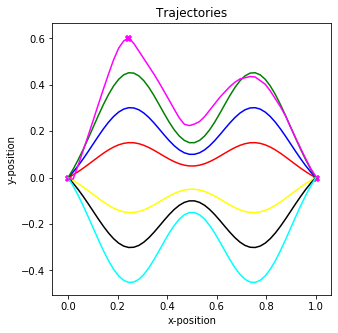

In [23]:
model2.load_weights('best_validation_exp1.h5')
test_plt_model5(cx1,cy1,cx2,cy2,cx3,cy3,4)

### Closing the loop
* At last, the found trajectory is added to CNMP dataset and CNMP is trained further.
* test_plt_model5 function saves the new found trajectory as <b>y[6]</b>
* Same get_train_sample function is used where p is selected between 0 and 6 instead of 0 and 5 to include new found trajectory
* Training of CNMP is exactly the same but we let the training continue instead of starting over.

In [24]:
def get_train_sample2():
    observation = np.zeros((1,n_max,2))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,1))
    p = random.randint(0, 6)
    n = random.randint(1,n_max)
    perm = np.random.permutation(50)
    for i in range(n):
        observation[0,i] = [times[perm[i]],y[p,perm[i]]]
        observation_flag[0,0,i] = 1./n
    target[0,0,0] = times[perm[n]]
    return [observation,observation_flag,target], [[[y[p,perm[n]],0.]]],p

In [27]:
training_loss2 = np.zeros(2000)
for step in range(250000):
    inp,out,sample = get_train_sample2()
    data2 = model.fit(inp,out,batch_size=1,verbose=0)

    if step % 10000 == 0:
        #display.clear_output(wait=True)
        #display.display(pl.gcf())
        inp,out,sample = get_train_sample()
        #test_plt_model(cx2,0.6)
        #test_plt_model(c_x=0.5,c_y=0.13)
        #test_plt_model(c_x=0.25,c_y=0.37)

        mean_loss2 = np.zeros((100))
        for i in range(100):
            mean_loss2[i] = np.mean(training_loss2[i*20:(i+1)*20])


KeyboardInterrupt: 

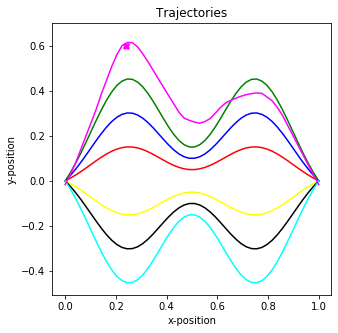

<Figure size 1440x720 with 0 Axes>

In [28]:
test_plt_model(cx2,cy2)